# Ensemble Challenge: Customer Churn Prediction

The challenge of predicting whether a customer will leave the customer portfolio (also known as churn) it's not just a retail problem, being a grouth area on constant study for most industries and service companies that depend on retention.<br>

This is an example type of problem that the scientists from the Luizalabs dive deeply and whose solutions serve to leverage several work fronts. The solution itself brings a lot of value, if it has a high accuracy, it can be used to automatically rank customers with a high risk of churn for an aggressive promotion with the objective of retaining them in the base.<br>

There is also a lot of value in the insights and validation of hypotheses that take place during the process of analyzing the problem and solutions. It can be verified through experimentation that, for example, a customer who buys exclusively on special dates or promotional events has a lower chance of being a churn than one who buys large volumes of the same product.<br>

# Challenge Objectives<br>
This challenge was built in a partnership between <b>Tera</b> and <b>Luizalabs</b>, the main proposal will be to build some solution based on machine learning to predict, if a given Magalu e-commerce customer will continue buying on the platform in 2020 using the customers characteristics and their purchase history in the previous year. At the end, some of these solutions must be combined into an ensemble to create a single solution with the aim of further leveraging results.<br>

In order for the <b>main objective</b> to be accomplished, it will be necessary to build a form of visualization of the created solutions and the comparison with the <b>baseline model</b> and the ensemble model created in the process. The suggested format is a <b>table results</b> the metrics for each model created.<br>

The <b>secondary objective</b> is to raise hypotheses and insights that emerge during the experiments. It is interesting to do this from the beginning as part of EDA, documenting each evidence of new information about the problem. It is also good practice to evaluate trained models, either by exploring their parameters (for example, the weights of a linear model) or using advanced techniques such as [SHAP](https://www.kaggle.com/dansbecker/shap-values), seeking to relate how the features influence the model's responses.<br>

The simplest way to accomplish the <b>secondary objective</b> is to document the analysis and EDA steps in summary form in a report that compiles the main hypotheses and insights. This report can be a text document in the form of a logbook or even a section in this notebook itself where the solution was developed.<br>

## Challenge Score

This challenge also has a <b>score dataset</b>, containing data from customers that are not in the training or test datasets. For these customers, responses <b>(targets)</b> were not available, so it is impossible to verify during solution development whether the model is correct or not.

The purpose of this <b>dataset</b> is to allow students to compare their best solutions with others fairly. Through this [link](https://forms.gle/9Vb4VDVejXLz6wi67) it is possible to send the <b>response file</b> of the challenge. At the end of the challenge, the <b>ranking</b> of student registrations will be shown.

### Let the games begin!!

### Description of Tables and Columns
In this section, the tables and their columns of the challenge will be described. The links to the files and the description of each one are in the following sections. Some code definitions and extractions will already be done at this point, to facilitate the use of the data in the rest of the notebook and to facilitate the explanation of each element.

### Customer Data
Customer data is contained in 3 csv files already separated into training, testing and challenge. This was previously done so that the three datasets had fair distributions of the features of interest, faithfully representing the problem domain.

### Table Columns
The columns for the three files are:

- `client_id:` Globally unique client ID
- `birthdate:` Customer's date of birth
- `state:` State where the customer lives
- `gender:` Gender declared by the client
- `is_churn:` Dependent variable (target) that says whether the customer will churn or not

All columns in the Products Table are symbolic, representing the different categories of the Market Structure tree where the product is inserted.

The names of the subcategories inherit the name of the parent category, so that all the subcategories of the column `category_lv2` that start with "mk38:072" have as their parent category the `category_lv1` named "mk38:072", which in turn is a child of `category_lv0` named "mk38".

An example of categorization:

`category_lv0:` Broader product categories; e.g. "Electronics" or "Fashion"<br>
`category_lv1:` Subcategories; e.g. "Electronics->Notebooks"<br>
`category_lv2:` Sub-subcategories; e.g. "Electronics->Notebooks->UltraThin"<br>
and so on.

The `product_id` column is the global product reference, which can be merged with the sales table.

The columns of this table are described below.

The Entity ID columns are:
- `order_id`: identifier of the sale; may be repeated in other lines, as **each line corresponds to the purchase of a product by a customer**, who may have purchased other products in the same event.
- `client_id`: identifier of the customer who made the purchase
- `datetime`: date and time of purchase
- `units`: quantity of product units that were purchased in this purchase event
- `price`: unit price of the purchased product
- `payment_method`: payment method (credit, debit, _voucher_, etc) for the purchase
- `installments`: number of payment installments; if it is empty, it can be considered that it does not apply
- `delivery_days`: product delivery time
- `delivery_state`: state where the product was delivered; exactly matches the state in the customer tables
- `device`: means where the customer bought; e.g. website, mobile app, shopping terminal
- `source`: _marketing_ channel that generated the _lead_ and caused the customer to buy; for example, it could be a link on a partner page where the customer saw a promotion

### 1 -  Importing the main libraries for the case study

In [1]:
import pandas as pd
import janitor
import numpy as np
import gdown
from datetime import datetime
import shap
import category_encoders as ce
from dython.nominal import associations

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import iplot
from plotly import tools

from biokit.viz import corrplot
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import precision_score, plot_roc_curve, make_scorer, f1_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, confusion_matrix
from category_encoders.target_encoder import TargetEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

### 2 - Creating usefull functions

In [2]:
#Table for resume the some initial information from the datasets
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    summary['Third Value'] = df.iloc[2].values
 

    return summary

In [3]:
#Function to create bargraph using plotly
def plotting_bargraph(df,column_1, column_2, title = None, xlabel_1 = None, xlabel_2 = None, ylabel_1 = None, ylabel_2 = None):
    
    """df1 = Dataframe to be used for plotting
    
       column_1 = The first variable to use in the first graph
       
       column_2 = The second variable to use in the first graph
       
       title = Title of the graph
       
       xlabel_1 = First graph X label axis
       
       xlabel_2 = First graph Y label axis
       
       ylabel_1 = Second graph X label axis
       
       ylabel_2 = Second graph Y label axis
       
       """
    #Defining the subplot
    fig = tools.make_subplots(rows=1, cols=2, print_grid=True, horizontal_spacing=0.1, )

    #Creating Auxiliary datasets
    df_aux_churn = df[df['is_churn'] == False]
    df_aux_nochurn = df[df['is_churn'] == True]

    #First bargraph definitions
    trace1 = go.Bar(x = df_aux_churn[column_1].value_counts().sort_index().index,
                    y = df_aux_churn[column_1].value_counts().sort_index().values,
                    name='Churn (True)',opacity = 0.8, marker=dict(color='seagreen',
                    line=dict(color = '#000000', width = 1)))

    trace2 = go.Bar(x = df_aux_nochurn[column_1].value_counts().sort_index().index,
                    y = df_aux_nochurn[column_1].value_counts().sort_index().values,
                    name='Churn (False)', opacity = 0.8, marker = dict(color='indianred',
                    line = dict(color='#000000', width=1)))

    #Second bargraph definitions
    trace3 = go.Bar(x = df_aux_churn[column_2].value_counts().sort_index().index,
                    y = df_aux_churn[column_2].value_counts().sort_index().values,
                    name='Churn (True)',opacity = 0.8, marker=dict(color='seagreen',
                    line=dict(color = '#000000', width = 1)), showlegend=False)

    trace4 = go.Bar(x = df_aux_nochurn[column_2].value_counts().sort_index().index,
                    y = df_aux_nochurn[column_2].value_counts().sort_index().values,
                    name='Churn (False)', opacity = 0.8, marker = dict(color='indianred',
                    line = dict(color='#000000', width=1)), showlegend=False)

    #Updating X title, Y title and graph title
    fig['layout']['xaxis'].update(title= xlabel_1)
    fig['layout']['yaxis'].update(title= ylabel_1)
    fig['layout']['xaxis2'].update(title= xlabel_2)
    fig['layout']['yaxis2'].update(title= ylabel_2)
    fig['layout']['title'] =  title
    fig['layout']['height'] = 500
    fig['layout']['width'] = 1000


    #Appending the graphs in the subplot
    fig.append_trace(trace1, 1, 1) 
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 2) 
    fig.append_trace(trace4, 1, 2)
    fig.update_layout(legend = dict(y = 1, x = 0.85))
    return iplot(fig)

In [4]:
#Feature to create some features engineering
def create_features_engineering(df, methods, column):
    """df = Should be a datasetylou want to create new features
    methods = It is necessary to pass a list of mathods to create the features
    column = The name of the column that will be used for grouping """
    aux_df = pd.DataFrame()
    for method in methods:
        
        if type(method) == float:  
            aux_df_1 = df.groupby(column).quantile(method).drop(columns='datetime', axis =1)
            aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
            if aux_df.shape[0] == 0:
                aux_df = aux_df_1
            else:
                aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
        elif type(method) == str:
            if method == 'mean':
                aux_df_1 = df.groupby(column).mean()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'max':
                aux_df_1 = df.groupby(column).max()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'min':
                aux_df_1 = df.groupby(column).min()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            elif method == 'std':
                aux_df_1 = df.groupby(column).std()
                aux_df_1.columns = [(f'{i}_{method}') for i in aux_df_1.columns]
                if aux_df.shape[0] == 0:
                    aux_df = aux_df_1
                else:
                    aux_df = pd.merge(left = aux_df, right = aux_df_1, left_index=True, right_index=True)
            
            else:
                return (f'Method {method} Not Found')
        else:
            return (f'Method {method} Not Found')
    return aux_df

In [5]:
#Function to encode the datetime features
def encode_data_variables(df, column, max_val):
    data = pd.DataFrame()

    if (max_val == 30) and (column == 'datetime'):
        data['buy_month_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_month_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 24) and (column == 'datetime'):
        data['buy_hour_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_hour_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 7) and (column == 'datetime'):
        data['buy_day_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_day_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    elif (max_val == 365) and (column == 'datetime'):
        data['buy_year_sin'] = np.sin(2 * np.pi * df[column].astype('int64')/max_val)
        data['buy_year_cos'] = np.cos(2 * np.pi * df[column].astype('int64')/max_val)
    return data

In [6]:
#Features to calculate scores
def compute_score(X, y, model, classifier):
    y_pred = model.predict(X)
    scores = [accuracy_score(y, y_pred),
              precision_score(y, y_pred),
              recall_score(y, y_pred),
              f1_score(y, y_pred)]
    score_results = pd.DataFrame(scores,
                                 columns = [classifier],
                                 index = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).round(3)
    return score_results

### 3 - Creating, downloading and importing the datas the "/data" folder

In [7]:
%%bash
if [  -d "data" ]
then 
    echo "folder 'data' already created, do nothing" 
else
    mkdir data
    echo "created 'data' folder"
fi

folder 'data' already created, do nothing


In [8]:
FILE_INFO = {
    'client_tr': {
        'url':      'https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm',
        'output':   'data/client.train.csv'
    },
    'client_te': {
        'url':      'https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw',
        'output':   'data/client.test.csv'
    },
    'client_ch': {
        'url':      'https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV',
        'output':   'data/client.challenge.csv'
    },
    'orders': {
        'url':      'https://drive.google.com/uc?id=1sk7p66kMAu4ZfAUmYVH0YF-cx2kHd4UZ',
        'output':   'data/orders.csv'
    },
    'product': {
        'url':      'https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ',
        'output':   'data/product.csv'
    }
}

In [9]:
key1 = 'client_tr'
key2 = 'client_te'
key3 = 'client_ch'
key4 = 'product'
key5 = 'orders'

In [10]:
gdown.download(**FILE_INFO[key1], quiet=0)
gdown.download(**FILE_INFO[key2], quiet=0)
gdown.download(**FILE_INFO[key3], quiet=0)
gdown.download(**FILE_INFO[key4], quiet=0)
gdown.download(**FILE_INFO[key5], quiet=0)

Downloading...
From: https://drive.google.com/uc?id=1GaDgzqFJz-ATMU5ePDD7BPjpSjzZ7kQm
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.train.csv
100%|████████████████████████████████████████████████████████████████████████████████| 788k/788k [00:01<00:00, 623kB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pg6AIpM-krtf1aNS3IKUSkoHhun_OxKw
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.test.csv
100%|███████████████████████████████████████████████████████████████████████████████| 263k/263k [00:00<00:00, 1.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JBo7SlIuzmkQgRg9VytkNgXLhZyKmPJV
To: C:\Users\eoliv\projetos python\Tera\Python\11 - Desafio de Ensemble\data\client.challenge.csv
100%|███████████████████████████████████████████████████████████████████████████████| 217k/217k [00:00<00:00, 1.29MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wU65H2mwrdd8BhVM8hITCB9sfRVNHFwQ
To: C:\User

'data/orders.csv'

In [11]:
clients_tr = pd.read_csv(
    FILE_INFO[key1]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_te = pd.read_csv(
    FILE_INFO[key2]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
clients_ch = pd.read_csv(
    FILE_INFO[key3]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['birthdate']
)
product = pd.read_csv(
    FILE_INFO[key4]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8'
)
orders = pd.read_csv(
    FILE_INFO[key5]['output'],
    index_col=0, 
    sep=',', 
    encoding='utf-8',
    parse_dates=['datetime']
)
display (clients_ch.head(2), clients_te.head(2), clients_tr.head(2))
display (product.head(2), orders.head(2))

birthdate state gender
client_id                        
cx12525   1932-04-19  st15    cg1
cx32280   1983-03-01  st15    cg1

birthdate state gender  is_churn
client_id                                  
cx06840   1982-12-03  st15    cg1     False
cx01931   1979-05-09  st15    cg1     False

birthdate state gender  is_churn
client_id                                  
cx05072   1972-03-22  st25    cg2     False
cx03836   1966-08-14  st15    cg1     False

category_lv0 category_lv1  category_lv2      category_lv3  \
product_id                                                             
px01237            mk38     mk38:072  mk38:072:149  mk38:072:149:218   
px11510            mk38     mk38:072  mk38:072:149  mk38:072:149:218   

                      category_lv4  
product_id                          
px01237     mk38:072:149:218:04846  
px11510     mk38:072:149:218:01337

client_id product_id            datetime  units  price  \
order_id                                                          
ox008433   cx05072    px04611 2019-10-07 15:20:00    1.0   49.9   
ox070389   cx05072    px12305 2019-10-11 17:42:00    1.0   69.9   

         payment_method  installments  delivery_days delivery_state device  \
order_id                                                                     
ox008433           pm05           NaN            NaN           st07    dv9   
ox070389           pm05           NaN            NaN           st07    dv9   

         source  
order_id         
ox008433   sc08  
ox070389   sc08

### 4 - EDA

In [12]:
#Whole overview
display(resumetable(clients_tr.reset_index()))
display(resumetable(clients_ch.reset_index()))
display(resumetable(clients_te.reset_index()))
display(resumetable(orders.reset_index()))
display(resumetable(product.reset_index()))

Dataset Shape: (23292, 5)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0    23292              cx05072   
1  birthdate  datetime64[ns]        0    13046  1972-03-22 00:00:00   
2      state          object        0       27                 st25   
3     gender          object        0        2                  cg2   
4   is_churn            bool        0        2                False   

          Second Value          Third Value  
0              cx03836              cx08472  
1  1966-08-14 00:00:00  1954-08-07 00:00:00  
2                 st15                 st15  
3                  cg1                  cg1  
4                False                False

Dataset Shape: (7765, 4)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0     7765              cx12525   
1  birthdate  datetime64[ns]        0     6210  1932-04-19 00:00:00   
2      state          object        0       24                 st15   
3     gender          object        0        2                  cg1   

          Second Value          Third Value  
0              cx32280              cx00471  
1  1983-03-01 00:00:00  1964-08-30 00:00:00  
2                 st15                 st15  
3                  cg1                  cg2

Dataset Shape: (7764, 5)


Name          dtypes  Missing  Uniques          First Value  \
0  client_id          object        0     7764              cx06840   
1  birthdate  datetime64[ns]        0     6252  1982-12-03 00:00:00   
2      state          object        0       25                 st15   
3     gender          object        0        2                  cg1   
4   is_churn            bool        0        2                False   

          Second Value          Third Value  
0              cx01931              cx35431  
1  1979-05-09 00:00:00  1965-05-09 00:00:00  
2                 st15                 st15  
3                  cg1                  cg1  
4                False                False

Dataset Shape: (168472, 12)


Name          dtypes  Missing  Uniques          First Value  \
0         order_id          object        0   133209             ox008433   
1        client_id          object        0    38821              cx05072   
2       product_id          object        0    12535              px04611   
3         datetime  datetime64[ns]        0   102263  2019-10-07 15:20:00   
4            units         float64        0     3373                  1.0   
5            price         float64        0    26391                 49.9   
6   payment_method          object        0       14                 pm05   
7     installments         float64   131927       24                  NaN   
8    delivery_days         float64    78830       71                  NaN   
9   delivery_state          object        0       26                 st07   
10          device          object        0        9                  dv9   
11          source          object        0       16                 sc08   

           Second Value          Third Value  
0              ox070389             ox061137  
1               cx05072              cx06840  
2               px12305              px07033  
3   2019-10-11 17:42:00  2019-01-19 13:09:00  
4                   1.0                  1.0  
5                  69.9                 35.9  
6                  pm05                 pm05  
7                   NaN                  NaN  
8                   NaN                  NaN  
9                  st07                 st07  
10                  dv9                  dv9  
11                 sc08                 sc08

Dataset Shape: (12659, 6)


Name  dtypes  Missing  Uniques             First Value  \
0    product_id  object        0    12659                 px01237   
1  category_lv0  object        0       52                    mk38   
2  category_lv1  object        0      296                mk38:072   
3  category_lv2  object        0      893            mk38:072:149   
4  category_lv3  object        0     1218        mk38:072:149:218   
5  category_lv4  object        0    10763  mk38:072:149:218:04846   

             Second Value             Third Value  
0                 px11510                 px03782  
1                    mk38                    mk38  
2                mk38:072                mk38:072  
3            mk38:072:149            mk38:072:019  
4        mk38:072:149:218        mk38:072:019:066  
5  mk38:072:149:218:01337  mk38:072:019:066:02321

In [13]:
#Treating NA values using iterative inputer
imp = IterativeImputer(estimator=RandomForestClassifier(), random_state=333)
array_for_isna = imp.fit_transform(orders[['installments','delivery_days']])
orders[['installments','delivery_days']] = array_for_isna

In [14]:
clients_tr.head()

birthdate state gender  is_churn
client_id                                  
cx05072   1972-03-22  st25    cg2     False
cx03836   1966-08-14  st15    cg1     False
cx08472   1954-08-07  st15    cg1     False
cx12946   1955-11-16  st15    cg1     False
cx19045   1958-10-25  st15    cg2     False

In [15]:
print("Customer Churn:")
print(round(clients_tr['is_churn'].value_counts(normalize=True) * 100,2))

trace0 = go.Bar(x = clients_tr.reset_index().groupby('is_churn')['client_id'].count().index,
                y = clients_tr.reset_index().groupby('is_churn')['client_id'].count().values,
                marker = dict(color = ['seagreen','indianred']))

data = [trace0]
layout = go.Layout(title='Churn Distribution', xaxis=dict(title='Customes Churn'), yaxis=dict(title='Count'))

fig = go.Figure(data=data, layout=layout)
iplot(fig)

Customer Churn:
False    81.94
True     18.06
Name: is_churn, dtype: float64


We see 18.06% of the customers which is the amount of churn considering this amount, let's understando in another plots, the what's the impact for this percentage of churn.
- The lost price for 18.06% of churn
- The State of the churn customers
- the gender of the customers
- The age of the customers

### 5 - Creating some features engineerings

In [16]:
#For creating other plots, let's create auxililiary dataframes and join in clients_tr aind orders, using client id to join
aux_sum_clients_price_and_units = orders.groupby('client_id').sum()[['price', 'units']]
aux_df_clients_with_price = clients_tr.join(aux_sum_clients_price_and_units)
aux_df_clients_with_price['age'] = datetime.today().year - aux_df_clients_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
price_bins = [-30000, 0, 10000,25000, 50000, 75000, aux_df_clients_with_price.price.max()]
price_labels = ['less zero', '0-10000','10001-25000','25001-50000','50001-75000','75001-above']
aux_df_clients_with_price['price_cat'] = pd.cut(aux_df_clients_with_price.price, bins = price_bins, labels = price_labels).astype('object')
aux_df_clients_with_price['age_cat'] = pd.cut(aux_df_clients_with_price.age, bins = age_bins, labels = age_labels).astype('object')

In [17]:
aux_df_clients_with_price.shape

(23292, 9)

In [18]:
display(orders.shape)
display(product.shape)

(168472, 11)

(12659, 5)

In [19]:
orders_grouped_product = product.join(orders.set_index('product_id')).set_index('client_id').drop(columns=['units', 'price'])
orders_grouped_product.shape

(168596, 12)

In [20]:
final_df = aux_df_clients_with_price.join(orders_grouped_product)
final_df.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

In [21]:
final_df.shape

(101005, 19)

In [22]:
#Using describe to understand the statistical values
final_df.describe()

price          units            age   installments  \
count  101005.000000  101005.000000  101005.000000  101005.000000   
mean     3179.482216      12.672396      44.737924       1.897698   
std      4077.991326      27.989998      13.631245       2.804587   
min    -25175.890000       1.000000      12.000000       1.000000   
25%       883.590000       4.000000      34.000000       1.000000   
50%      2164.310000       7.000000      42.000000       1.000000   
75%      4174.130000      12.000000      54.000000       1.000000   
max     94936.510000     940.000000     122.000000      24.000000   

       delivery_days  
count  101005.000000  
mean        4.619474  
std         5.523377  
min         0.000000  
25%         2.000000  
50%         2.000000  
75%         6.000000  
max       165.000000

In [23]:
plotting_bargraph(final_df, 'gender', 'state', 'Churn Rate Distribution by Gender and State ',
                  'Gender', 'State', 'Churn Count', 'Churn Count')
plotting_bargraph(final_df, 'price_cat', 'age_cat', 'Churn Rate Distribution by Price and Age ',
                  'Price', 'Age', 'Churn Count', 'Churn Count')

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



Text(0, 0.5, 'Count')

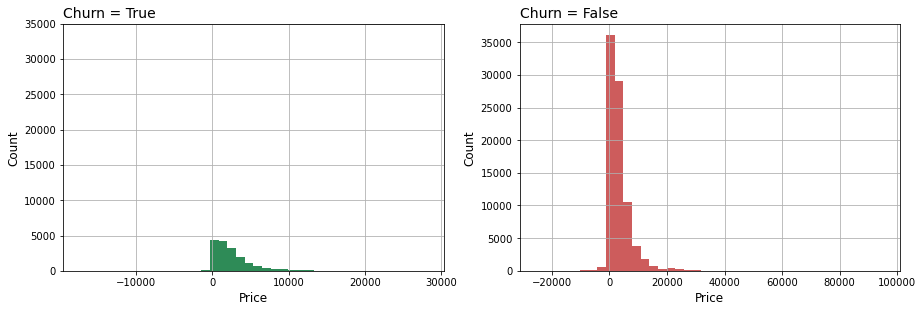

In [24]:
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(221)
ax1= plt.hist(final_df[final_df['is_churn'] == True]['price'], color = 'seagreen', bins = 40)
ax1 = plt.title('Churn = True', fontsize = 14, loc = 'left')
plt.grid(True)
plt.yticks(np.arange(0,40000, 5000))
plt.xlabel('Price', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
fig.add_subplot(222)
ax2 = plt.hist(final_df[final_df['is_churn'] == False]['price'], color = 'indianred', bins = 40)
ax2 = plt.title('Churn = False', fontsize = 14,loc = 'left')
plt.grid(True)
plt.xlabel('Price', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

We have negative prices, this occurs because the return of the purchases. Let's plot a box plot to see in another perspective.

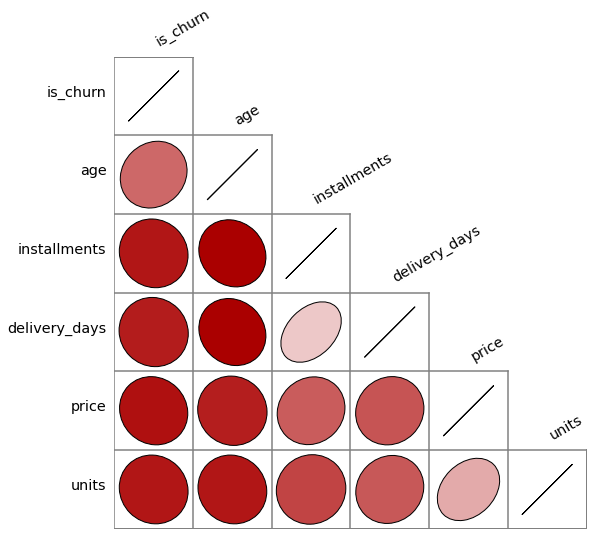

In [25]:
#Creating correlation matrix for numerical features
correlation_matrix = final_df.corr()
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

In [26]:
#Creating assosiations matrix for nominal features and numerical features
#First we will create 2 variables, categorical and numerical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
nom_corr = associations(dataset = final_df,
                        nominal_columns=categorical_columns,
                        numerical_columns=numerical_columns,
                        figsize=(15,15),
                        cmap ='Blues',
                        plot=False,
                        compute_only=True)

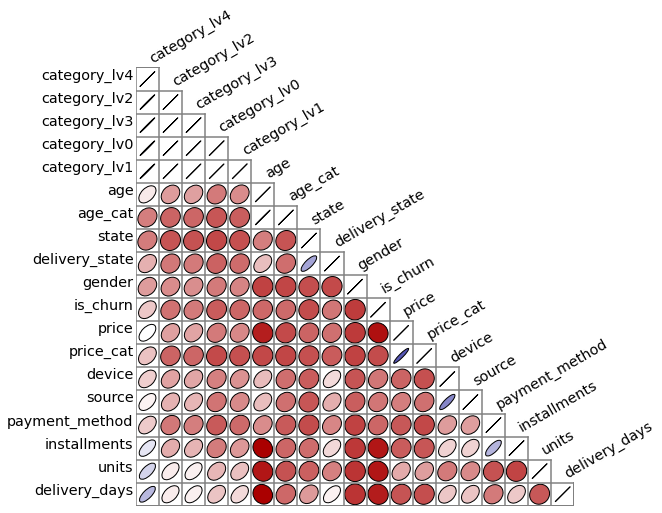

In [27]:
#Ploting Nominal Assotiation
correlation_matrix = nom_corr['corr']
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

We see that for the classification the most important features are the features wich is related for the product and its category.

### 6 - Training the baseline model 

In [28]:
#Let's encode the categorical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
target = TargetEncoder()
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.fit_transform(final_df[categorical_columns], final_df.is_churn)

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})

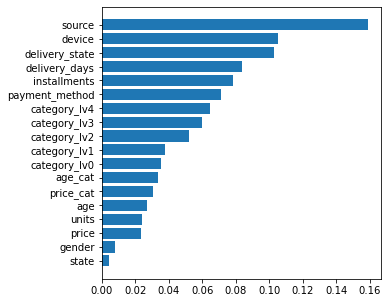

In [29]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn
#We have 18% for churn and 82#forno churn, let's create the simetry between target
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=333)
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
#Predicting the y values
y_pred_rfc = model_rfc.predict(X_test)

coef = model_rfc.feature_importances_
features = X_train.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,5))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

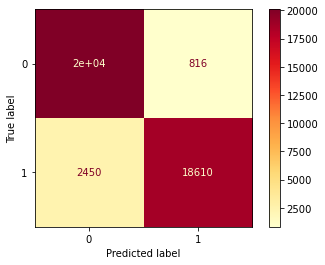

In [30]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc, X_test, y_test, cmap='YlOrRd')

In [31]:
#Printing the score for train e test for comparision
y_pred_train = model_rfc.predict(X_train)
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_train, y_pred_train),3)}\n\
Precision: {round(precision_score(y_train, y_pred_train),3)}\n\
Recall: {round(recall_score(y_train, y_pred_train),3)}')
print('========Test Results 1========')

print(f'Accuracy: {round(accuracy_score(y_test, y_pred_rfc),3)}\n\
Precision: {round(precision_score(y_test, y_pred_rfc),3)}\n\
Recall: {round(recall_score(y_test, y_pred_rfc),3)}')

========Train Results========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
========Test Results 1========
Accuracy: 0.922
Precision: 0.958
Recall: 0.884


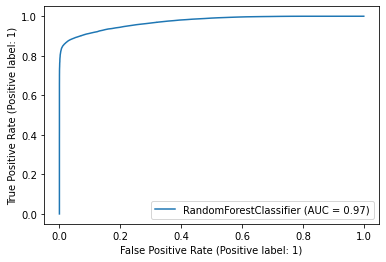

In [32]:
plot_roc_curve(model_rfc, X_test, y_test)

After EDA, feature engineering creation and model trainining, we can conclude that the model have a good performance cosidering all features. Before chosing the features that is the most representative for the model, let's create more fetures to understand the behavoir of the model with new features engineering.

### 7 - Creating more features engineerings with create_features_by_product function and encode_data_variables function

In [33]:
#Using the feature engineering function to create addictional features ordered by product_id
orders_with_features_engineerings = create_features_engineering(orders, [0.25,0.50,0.75,0.95,'std', 'mean', 'max', 'min'],
                                                               'client_id')
orders_with_features_engineerings.shape

(38821, 44)

In [34]:
#Merging datasets orders with features engineering and product
final_df = final_df.merge(orders_with_features_engineerings, left_index=True, right_index=True)

In [35]:
#Treating NA values using simple imputer and most frequent strategy
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)] =\
imp.fit_transform(final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)])

In [36]:
#Using describe to understand the statistical values
final_df.describe()

price          units            age   installments  \
count  101005.000000  101005.000000  101005.000000  101005.000000   
mean     3179.482216      12.672396      44.737924       1.897629   
std      4077.991326      27.989998      13.631245       2.806770   
min    -25175.890000       1.000000      12.000000       1.000000   
25%       883.590000       4.000000      34.000000       1.000000   
50%      2164.310000       7.000000      42.000000       1.000000   
75%      4174.130000      12.000000      54.000000       1.000000   
max     94936.510000     940.000000     122.000000      24.000000   

       delivery_days     units_0.25     price_0.25  installments_0.25  \
count  101005.000000  101005.000000  101005.000000      101005.000000   
mean        4.619474       1.032835     132.613935           1.243171   
std         5.523377       0.474259     477.889654           1.292782   
min         0.000000       0.027305   -5494.080000           1.000000   
25%         2.000000       1.000000      23.000000           1.000000   
50%         2.000000       1.000000      67.250000           1.000000   
75%         6.000000       1.000000     186.172500           1.000000   
max       165.000000      30.000000    8621.570000          24.000000   

       delivery_days_0.25      units_0.5  ...  installments_mean  \
count       101005.000000  101005.000000  ...      101005.000000   
mean             3.049250       1.097965  ...           1.897629   
std              2.944349       0.712901  ...           1.872665   
min              0.000000       0.173870  ...           1.000000   
25%              2.000000       1.000000  ...           1.000000   
50%              2.000000       1.000000  ...           1.000000   
75%              2.000000       1.000000  ...           2.000000   
max             66.000000      30.000000  ...          24.000000   

       delivery_days_mean      units_max      price_max  installments_max  \
count       101005.000000  101005.000000  101005.000000     101005.000000   
mean             4.619474       2.190298    1410.358975          3.990109   
std              3.838497       3.820677    1134.651041          4.965878   
min              0.000000       1.000000       0.000000          1.000000   
25%              2.000000       1.000000     594.000000          1.000000   
50%              3.166667       1.000000    1199.000000          1.000000   
75%              5.750000       2.000000    1999.000000          6.000000   
max             66.500000     110.000000   25648.900000         24.000000   

       delivery_days_max      units_min      price_min  installments_min  \
count      101005.000000  101005.000000  101005.000000     101005.000000   
mean            9.548012       0.924642    -181.199037          1.112074   
std             9.345582       0.375889     804.964584          0.953045   
min             0.000000       0.000100   -8999.000000          1.000000   
25%             2.000000       1.000000    -108.900000          1.000000   
50%             7.000000       1.000000       9.900000          1.000000   
75%            13.000000       1.000000      59.900000          1.000000   
max           165.000000      30.000000    6119.100000         24.000000   

       delivery_days_min  
count      101005.000000  
mean            2.252562  
std             2.424825  
min             0.000000  
25%             2.000000  
50%             2.000000  
75%             2.000000  
max            66.000000  

[8 rows x 37 columns]

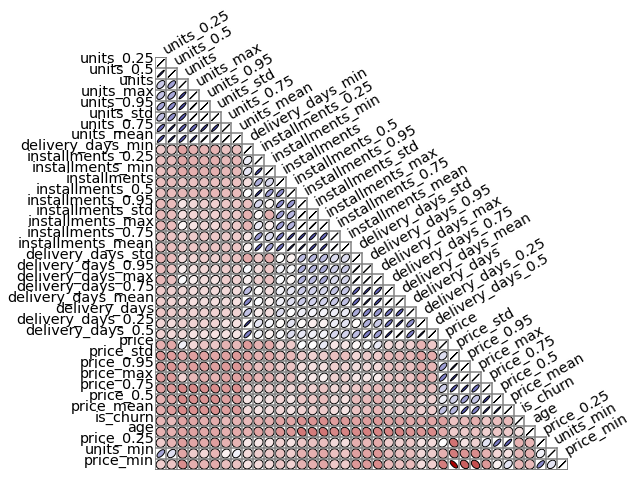

In [37]:
#Creating correlation matrix for numerical features
correlation_matrix = final_df.corr()
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(15,10)

In [38]:
#Creating assosiations matrix for nominal features and numerical features
#First we will create 2 variables, categorical and numerical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
nom_corr = associations(dataset = final_df,
                        nominal_columns=categorical_columns,
                        numerical_columns=numerical_columns,
                        figsize=(15,15),
                        cmap ='Blues',
                        plot=False,
                        compute_only=True)

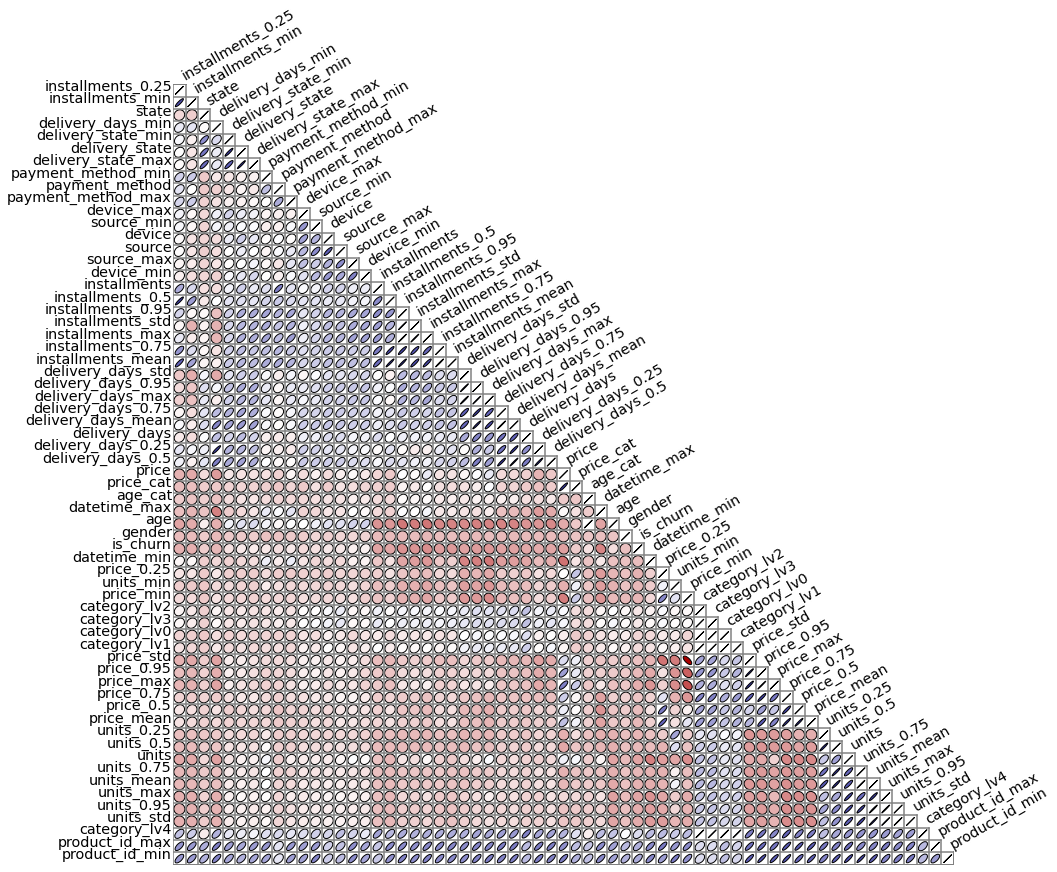

In [39]:
#Ploting Nominal Assotiation
correlation_matrix = nom_corr['corr']
correlation_matrix = corrplot.Corrplot(correlation_matrix)
correlation_matrix.plot(colorbar=False, shrink=.9 , lower = 'ellipse', fontsize='x-large')
ax = plt.gcf()
ax.figure.set_size_inches(20,20)

### 6 - Re-training the baseline model

In [40]:
#Let's encode the categorical features
target = TargetEncoder()
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.fit_transform(final_df[categorical_columns], final_df.is_churn)

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})
final_df_encoded.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

In [41]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn

In [42]:
#We have 18% for churn and 82% for no churn, let's create the simetry between target features and the explaners
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=333)

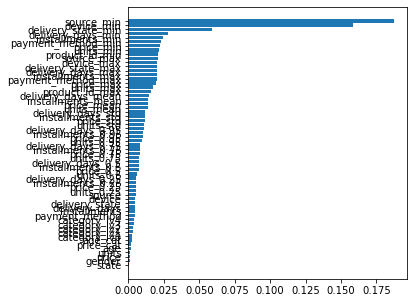

In [43]:
model_rfc_2 = RandomForestClassifier()
model_rfc_2.fit(X_train, y_train)
#Predicting the y values
y_pred_rfc_2 = model_rfc_2.predict(X_test)

coef = model_rfc_2.feature_importances_
features = X_train.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,5))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

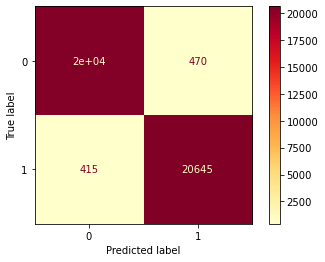

In [44]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc_2, X_test, y_test, cmap='YlOrRd')

In [45]:
#Printing the score for train e test for comparision
y_pred_train_2 = model_rfc_2.predict(X_train)
print('========Train Results========')
print(f'Accuracy: {round(accuracy_score(y_train, y_pred_train_2),3)}\n\
Precision: {round(precision_score(y_train, y_pred_train_2),3)}\n\
Recall: {round(recall_score(y_train, y_pred_train_2),3)}')
print('========Test Results 2========')

print(f'Accuracy: {round(accuracy_score(y_test, y_pred_rfc_2),3)}\n\
Precision: {round(precision_score(y_test, y_pred_rfc_2),3)}\n\
Recall: {round(recall_score(y_test, y_pred_rfc_2),3)}')

========Train Results========
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
========Test Results 2========
Accuracy: 0.979
Precision: 0.978
Recall: 0.98


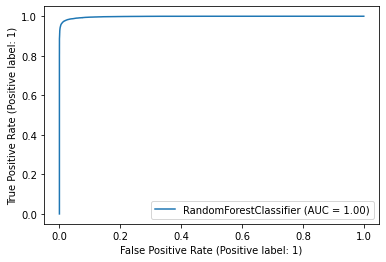

In [46]:
plot_roc_curve(model_rfc_2, X_test, y_test)

In [47]:
#Cross Validation Tests, considering the test with higher recall score, in our case is the test with features engineering
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)} 
cv = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_validate(estimator = model_rfc_2,
                            X = X,
                            y = y,
                           cv = cv,
                      scoring = scoring)

In [48]:
#Reporting the results of all
train_score =[accuracy_score(y_train, y_pred_train_2),
              precision_score(y_train, y_pred_train_2),
              recall_score(y_train, y_pred_train_2),
              f1_score(y_train, y_pred_train_2)]
test_score_with_defaut_features = [accuracy_score(y_test, y_pred_rfc),
                                   precision_score(y_test, y_pred_rfc),
                                   recall_score(y_test, y_pred_rfc),
                                   f1_score(y_test, y_pred_rfc)]
test_score_with_features_engineering = [accuracy_score(y_test, y_pred_rfc_2),
                                        precision_score(y_test, y_pred_rfc_2),
                                        recall_score(y_test, y_pred_rfc_2),
                                        f1_score(y_test, y_pred_rfc_2)]
test_score_cv = [results['test_accuracy'].mean(),
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_f1_score'].mean()]


In [49]:
score_results = pd.DataFrame([train_score, test_score_with_defaut_features, test_score_with_features_engineering,
                              test_score_cv],
            index = ['Train Score', 'Test Score With Defaut Features', 'Test Score With Features Engineering',
                     'Test Score CrossValidation+Featuring'],
            columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).round(3)
score_results

Accuracy  Precision  Recall  F1 Score
Train Score                              1.000      1.000   1.000     1.000
Test Score With Defaut Features          0.922      0.958   0.884     0.919
Test Score With Features Engineering     0.979      0.978   0.980     0.979
Test Score CrossValidation+Featuring     0.975      0.991   0.862     0.922

As we can see in the dataframe results above, the best performance is when we have the Model with features engineering where the Recall is the most relevantfor the churn (predict less wrongly False Negative) with 98% of score.
Now we finished the model, we can reply for client_te.

### 7 - Now we will consider the clients_te dataset for the models above

In [50]:
#Let's prepare the dataset for prediction
#For creating other plots, let's create auxililiary dataframes and join in clients_tr aind orders, using client id to join
aux_df_clients_with_price = clients_te.join(aux_sum_clients_price_and_units)
aux_df_clients_with_price['age'] = datetime.today().year - aux_df_clients_with_price['birthdate'].dt.year
age_bins = [0,20,30,40,50,60,70,aux_df_clients_with_price.age.max()]
age_labels = ['less-20','20-30','31-40','41-50','51-60','61-70','70-above']
price_bins = [-30000, 0, 10000,25000, 50000, 75000, aux_df_clients_with_price.price.max()]
price_labels = ['less zero', '0-10000','10001-25000','25001-50000','50001-75000','75001-above']
aux_df_clients_with_price['price_cat'] = pd.cut(aux_df_clients_with_price.price, bins = price_bins, labels = price_labels).astype('object')
aux_df_clients_with_price['age_cat'] = pd.cut(aux_df_clients_with_price.age, bins = age_bins, labels = age_labels).astype('object')

In [51]:
final_df = aux_df_clients_with_price.join(orders_grouped_product)
final_df.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

In [52]:
#Let's encode the categorical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
target = TargetEncoder()
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.fit_transform(final_df[categorical_columns], final_df.is_churn)

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})

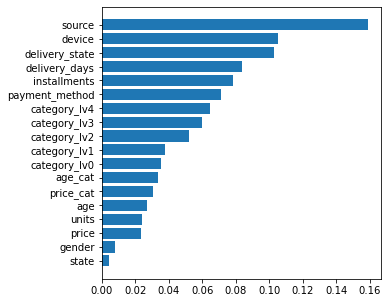

In [53]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn
#We have 18% for churn and 82#forno churn, let's create the simetry between target
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

#Predicting the y values
y_pred_rfc = model_rfc.predict(X_smote)

coef = model_rfc.feature_importances_
features = X_smote.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,5))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

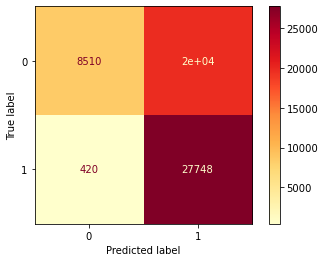

In [54]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc, X_smote, y_smote, cmap='YlOrRd')

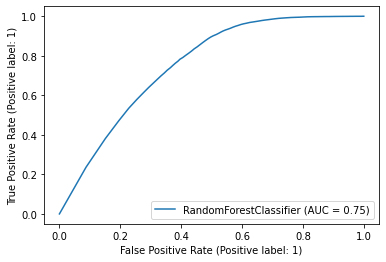

In [55]:
plot_roc_curve(model_rfc, X_smote, y_smote)

In [56]:
#Merging datasets orders with features engineering and product
final_df = final_df.merge(orders_with_features_engineerings, left_index=True, right_index=True)

In [57]:
#Treating NA values using simple imputer and most frequent strategy
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)] =\
imp.fit_transform(final_df[list(final_df.isnull().mean()[final_df.isnull().mean()!=0].index)])

In [58]:
#Let's encode the categorical features
categorical_columns = list(final_df.dtypes[final_df.dtypes == 'object'].index)
numerical_columns = list(final_df.dtypes[final_df.dtypes != 'object'].index)
target = TargetEncoder()
final_df_encoded = final_df.copy()
final_df_encoded[categorical_columns] = target.fit_transform(final_df[categorical_columns], final_df.is_churn)

#Let's transforme the target feature in binary encode
final_df_encoded['is_churn'] = final_df['is_churn'].map({False:0, True:1})
final_df_encoded.drop(columns=list(final_df.dtypes[final_df.dtypes == 'datetime64[ns]'].index), inplace=True)

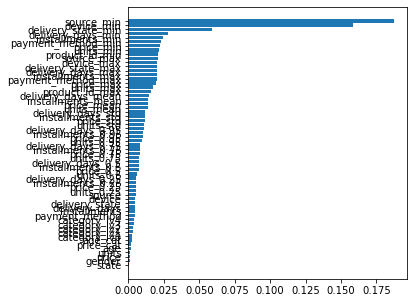

In [59]:
#Creating the model RandomForest for the first evaluation here we are considering just 4 features engineering 
#Age, Age category (spliting the age for groups), sum of price and price category (splitting by groups of prices)
X = final_df_encoded.drop(columns='is_churn')
y = final_df_encoded.is_churn
# let's create the simetry between target features and the explaners
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

#Predicting the y values
y_pred_rfc_2 = model_rfc_2.predict(X_smote)

coef = model_rfc_2.feature_importances_
features = X_smote.columns
coef, names = zip(*sorted(zip(coef,features)))
plt.figure(figsize = (5,5))
plt.barh(range(len(features)), coef, align='center')
plt.yticks(range(len(features)), features)
plt.show()

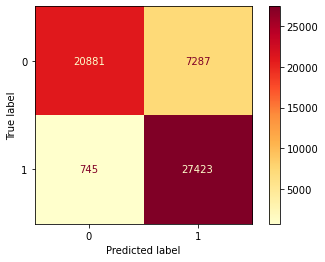

In [60]:
#Plotting confusion matrix
plot_confusion_matrix(model_rfc_2, X_smote, y_smote, cmap='YlOrRd')

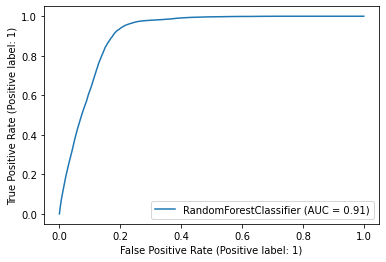

In [61]:
plot_roc_curve(model_rfc_2, X_smote, y_smote)

In [62]:
#Cross Validation Tests, considering the test with higher recall score, in our case is the test with features engineering
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)} 
cv = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_validate(estimator = model_rfc_2,
                            X = X_smote,
                            y = y_smote,
                           cv = cv,
                      scoring = scoring)

In [63]:
#Reporting the results of all

test_score_with_defaut_features = [accuracy_score(y_smote, y_pred_rfc),
                                   precision_score(y_smote, y_pred_rfc),
                                   recall_score(y_smote, y_pred_rfc),
                                   f1_score(y_smote, y_pred_rfc)]
test_score_with_features_engineering = [accuracy_score(y_smote, y_pred_rfc_2),
                                        precision_score(y_smote, y_pred_rfc_2),
                                        recall_score(y_smote, y_pred_rfc_2),
                                        f1_score(y_smote, y_pred_rfc_2)]
test_score_cv = [results['test_accuracy'].mean(),
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_f1_score'].mean()]

score_results_rf = pd.DataFrame([test_score_with_defaut_features, test_score_with_features_engineering,
                              test_score_cv],
            index = ['Test Score With Defaut Features', 'Test Score With Features Engineering',
                     'RandomForest_cross_validation'],
            columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).round(3)
score_results

Accuracy  Precision  Recall  F1 Score
Train Score                              1.000      1.000   1.000     1.000
Test Score With Defaut Features          0.922      0.958   0.884     0.919
Test Score With Features Engineering     0.979      0.978   0.980     0.979
Test Score CrossValidation+Featuring     0.975      0.991   0.862     0.922

Now Considering the trained model with clients_tr and testing the clients_te where the model had never seen the datas, we can see the the cross validation results was as much accurately as the others with Recall in 99.3%

<b>For the ensemble challenge we will consider the dataset with feature engineerings, which we saw much more performance and accurately in terms of Recall.</b>

### 8 - Bagging with Decision Tree

In [64]:
tree = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(base_estimator=tree, n_estimators=150, random_state=42)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150,
                  random_state=42)

           Bagging
Accuracy     0.862
Precision    0.837
Recall       0.900
F1 Score     0.867


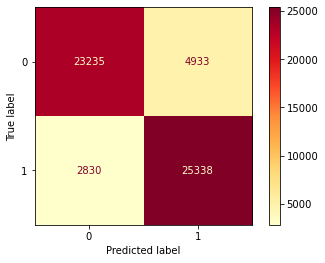

In [65]:
#Reporting the results of all
bagging_score = compute_score(X_smote, y_smote, bagging_clf, 'Bagging')
print(bagging_score)
plot_confusion_matrix(bagging_clf, X_smote, y_smote, cmap='YlOrRd')

### 9 - Random Forest Classifier

In [66]:
rf_clf = RandomForestClassifier(random_state=42, n_estimators=150)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

           Random Forest
Accuracy           0.842
Precision          0.769
Recall             0.976
F1 Score           0.861


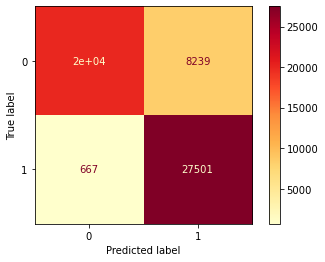

In [67]:
rf_score = compute_score(X_smote, y_smote, rf_clf, 'Random Forest')
print(rf_score)
plot_confusion_matrix(rf_clf, X_smote, y_smote, cmap='YlOrRd')

### 10 - ExtraTrees Classifier

In [68]:
ex_tree_clf = ExtraTreesClassifier(n_estimators=150, max_features=7, random_state=42)
ex_tree_clf.fit(X_train, y_train)

ExtraTreesClassifier(max_features=7, n_estimators=150, random_state=42)

           ExtraTree
Accuracy       0.762
Precision      0.692
Recall         0.945
F1 Score       0.799


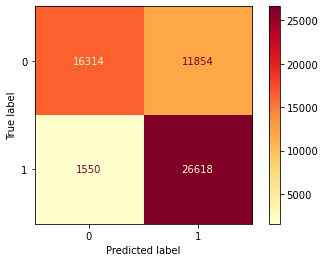

In [69]:
ex_tree_score = compute_score(X_smote, y_smote, ex_tree_clf, 'ExtraTree')
print(ex_tree_score)
plot_confusion_matrix(ex_tree_clf, X_smote, y_smote, cmap='YlOrRd')

### 11 - Adaboost Classifier

In [70]:
ada_boost_clf = AdaBoostClassifier(n_estimators=50)
ada_boost_clf.fit(X_train, y_train)

AdaBoostClassifier()

           Adaboost
Accuracy      0.840
Precision     0.759
Recall        0.997
F1 Score      0.862


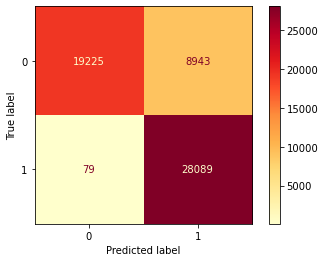

In [71]:
adaboost_score = compute_score(X_smote, y_smote, ada_boost_clf, 'Adaboost')
print(adaboost_score)
plot_confusion_matrix(ada_boost_clf, X_smote, y_smote, cmap='YlOrRd')

### 12 - GradientBoosting Classifier

In [72]:
grad_boost_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
grad_boost_clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

           GradientBoost
Accuracy           0.816
Precision          0.732
Recall             0.998
F1 Score           0.844


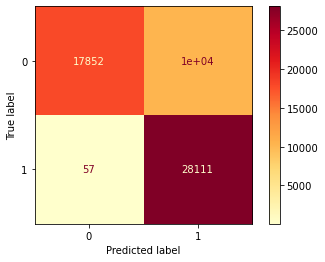

In [73]:
gradient_score = compute_score(X_smote, y_smote, grad_boost_clf, 'GradientBoost')
print(gradient_score)
plot_confusion_matrix(grad_boost_clf, X_smote, y_smote, cmap='YlOrRd')

### 13 - Voting Classifier

In [74]:
estimators = []
log_reg = LogisticRegression( solver='liblinear')
estimators.append(('Logistic', log_reg))

tree = DecisionTreeClassifier()
estimators.append(('Tree', tree))

svm_clf = SVC(gamma='scale')
estimators.append(('SVM', svm_clf))

voting = VotingClassifier(estimators=estimators)
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic',
                              LogisticRegression(solver='liblinear')),
                             ('Tree', DecisionTreeClassifier()),
                             ('SVM', SVC())])

           Voting
Accuracy    0.848
Precision   0.811
Recall      0.906
F1 Score    0.856


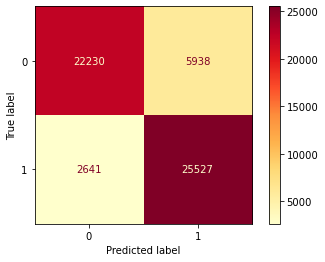

In [75]:
voting_score = compute_score(X_smote, y_smote, voting, 'Voting')
print(voting_score)
plot_confusion_matrix(voting, X_smote, y_smote, cmap='YlOrRd')

### 14 - Cross Validation with Xgboost Classifier

In [76]:
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(X_train, y_train)

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)} 
cv = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_validate(estimator = xgb_model,
                            X = X_smote,
                            y = y_smote,
                           cv = cv,
                      scoring = scoring)

test_score_cv = [results['test_accuracy'].mean(),
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_f1_score'].mean()]

y_pred = cross_val_predict(estimator = xgb_model,
                            X = X_smote,
                            y = y_smote,
                           cv = cv,)

           Xgboost+CV
Accuracy        0.989
Precision       0.988
Recall          0.989
F1 Score        0.989


<AxesSubplot:>

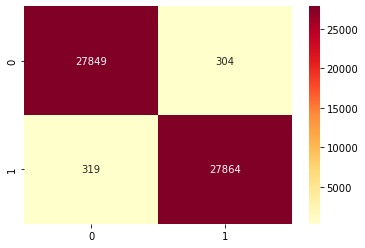

In [77]:
xgboost_score = pd.DataFrame(test_score_cv,
                             index = ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                             columns = ['Xgboost+CV']).round(3)
print(xgboost_score)
sns.heatmap(confusion_matrix(y_pred, y_smote), annot = True, fmt='.0f', cmap='YlOrRd')

### 15 - Stacking Classifier

In [ ]:
classifiers = [('extree', ex_tree_clf),
               ('adaboost', ada_boost_clf),                             
               ('xgb', xgb_model),
               ('rfc', rf_clf)]

clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)
clf.fit(X_train, y_train)

In [ ]:
#Concatenating all scores in one table
final_score_results = pd.concat([bagging_score, rf_score, ex_tree_score, adaboost_score, gradient_score,
                                 voting_score, xgboost_score], axis = 1)
final_score_results

Summarizing everything, we have the best performance using Xgboost classifier with cross validation, with the best scores. Considering is a churn study, the Recall is the score we need to focus and again Xgboost have the best performance.
In this challenge we didn't focus on Hyperparameters tuning and reduce the featureswhen fitting the models.
The second Step for reduce computing time with features reducing, tunning hyperparameters and testing a unique and best performance test.